In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator

In [7]:
train_path = "/kaggle/input/standard-ocr-dataset/data/training_data/"
test_path  = "/kaggle/input/standard-ocr-dataset/data/testing_data/"

In [8]:
# Get lables
labels = os.listdir(train_path)

In [9]:
# Define constants
IMG_SHAPE = (64, 64)
INPUT_SHAPE = (IMG_SHAPE[0], IMG_SHAPE[1], 3)
BATCH_SIZE = 32
EPOCHS = 10
loss = 'categorical_crossentropy'

In [10]:
# Get all image data
def get_data(filepath):
    images = []
    classes = []
    
    labels = os.listdir(filepath)
    for image_class in labels:
        ims = os.listdir(os.path.join(filepath, image_class))
        for i in range(0, len(ims)):
            im = cv2.imread(os.path.join(filepath, image_class, ims[i]))
            if im is not None:
                im = cv2.resize(im, IMG_SHAPE)
                im = np.array(im, dtype=np.float32)
                im = im / 255
                images.append(im)
                classes.append(image_class)            
            else:
                print(i, ims[i], image_class)
        
    return np.array(images), np.array(classes)

In [11]:
# Get test and train data
train_X, train_Y = get_data(train_path)
test_X, test_Y = get_data(test_path)

In [15]:
train_X.shape

(20628, 64, 64, 3)

In [16]:
train_X.shape[0] == train_Y.shape[0] and test_X.shape[0] == test_Y.shape[0]

True

In [17]:
# One hot encode labels
le = LabelEncoder()
train_Y = le.fit_transform(train_Y)

Text(0.5, 1.0, 'Label: 10')

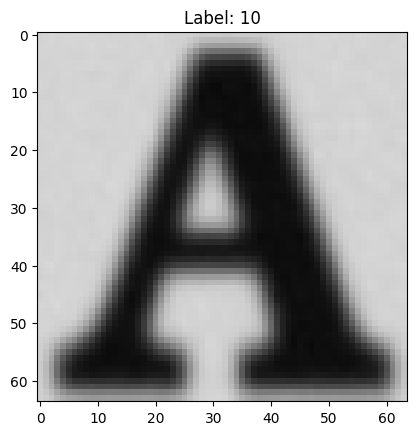

In [18]:
# Check image
test_image = 12022
plt.imshow(train_X[test_image], cmap="gray")
plt.title(f"Label: {train_Y[test_image]}")

In [19]:
# Data augmentation object
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,  # Don't flip for characters
    vertical_flip=False,  # Don't flip for characters
    fill_mode='nearest'
)

In [21]:
# Augment all the original data and place back into np arrays
augmented_arr_X = []
augmented_arr_Y = []
for i in range(len(train_X)):
  image_expanded = np.expand_dims(train_X[i], axis=0)
  augmented_images = [datagen.flow(image_expanded, batch_size=1).next()[0] for _ in range(5)]
  augmented_arr_X.append(augmented_images)
  augmented_arr_Y += [train_Y[i] for j in range(5)]
new_images = []
for row in augmented_arr_X:
  for image in row:
    new_images.append(image)

X = np.array(new_images)
Y = np.array(augmented_arr_Y)

In [22]:
X.shape

(103140, 64, 64, 3)

In [23]:
Y.shape

(103140,)

In [24]:
# Shuffle data
train_X, train_Y = shuffle(X, Y, random_state=42)

In [26]:
# Define model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D())
model.add(Conv2D(filters=32, kernel_size=(3,3),  activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64, kernel_size=(3,3),  activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=36, activation='softmax'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 64)          0

In [28]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [29]:
history = model.fit(train_X, train_Y, validation_split=0.2, epochs=EPOCHS)

Epoch 1/10
2579/2579 [==============================] - 160s 61ms/step - loss: 0.5457 - accuracy: 0.8377 - val_loss: 0.2421 - val_accuracy: 0.9189
Epoch 2/10
2579/2579 [==============================] - 150s 58ms/step - loss: 0.2047 - accuracy: 0.9310 - val_loss: 0.1800 - val_accuracy: 0.9399
Epoch 3/10
2579/2579 [==============================] - 151s 58ms/step - loss: 0.1515 - accuracy: 0.9470 - val_loss: 0.1468 - val_accuracy: 0.9501
Epoch 4/10
2579/2579 [==============================] - 152s 59ms/step - loss: 0.1222 - accuracy: 0.9570 - val_loss: 0.1480 - val_accuracy: 0.9522
Epoch 5/10
2579/2579 [==============================] - 152s 59ms/step - loss: 0.1045 - accuracy: 0.9625 - val_loss: 0.1406 - val_accuracy: 0.9538
Epoch 6/10
2579/2579 [==============================] - 150s 58ms/step - loss: 0.0889 - accuracy: 0.9672 - val_loss: 0.1346 - val_accuracy: 0.9544
Epoch 7/10
2579/2579 [==============================] - 148s 57ms/step - loss: 0.0811 - accuracy: 0.9703 - val_loss: 0

In [30]:
# Shuffle test data
test_X, test_Y = shuffle(test_X, test_Y, random_state=42)

In [2]:
# One hot encode test data
le = LabelEncoder()
test_Y = le.fit_transform(test_Y)

NameError: name 'test_Y' is not defined

In [32]:
# Check accuracy
test_loss, test_accuracy = model.evaluate(test_X, test_Y)

32/32 [==============================] - 1s 17ms/step - loss: 0.0288 - accuracy: 0.9851


In [33]:
print(f"Test accuracy: {test_accuracy*100}% \t Test loss: {test_loss}")

Test accuracy: 98.51190447807312% 	 Test loss: 0.02877957373857498


In [34]:
# Get the keys
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

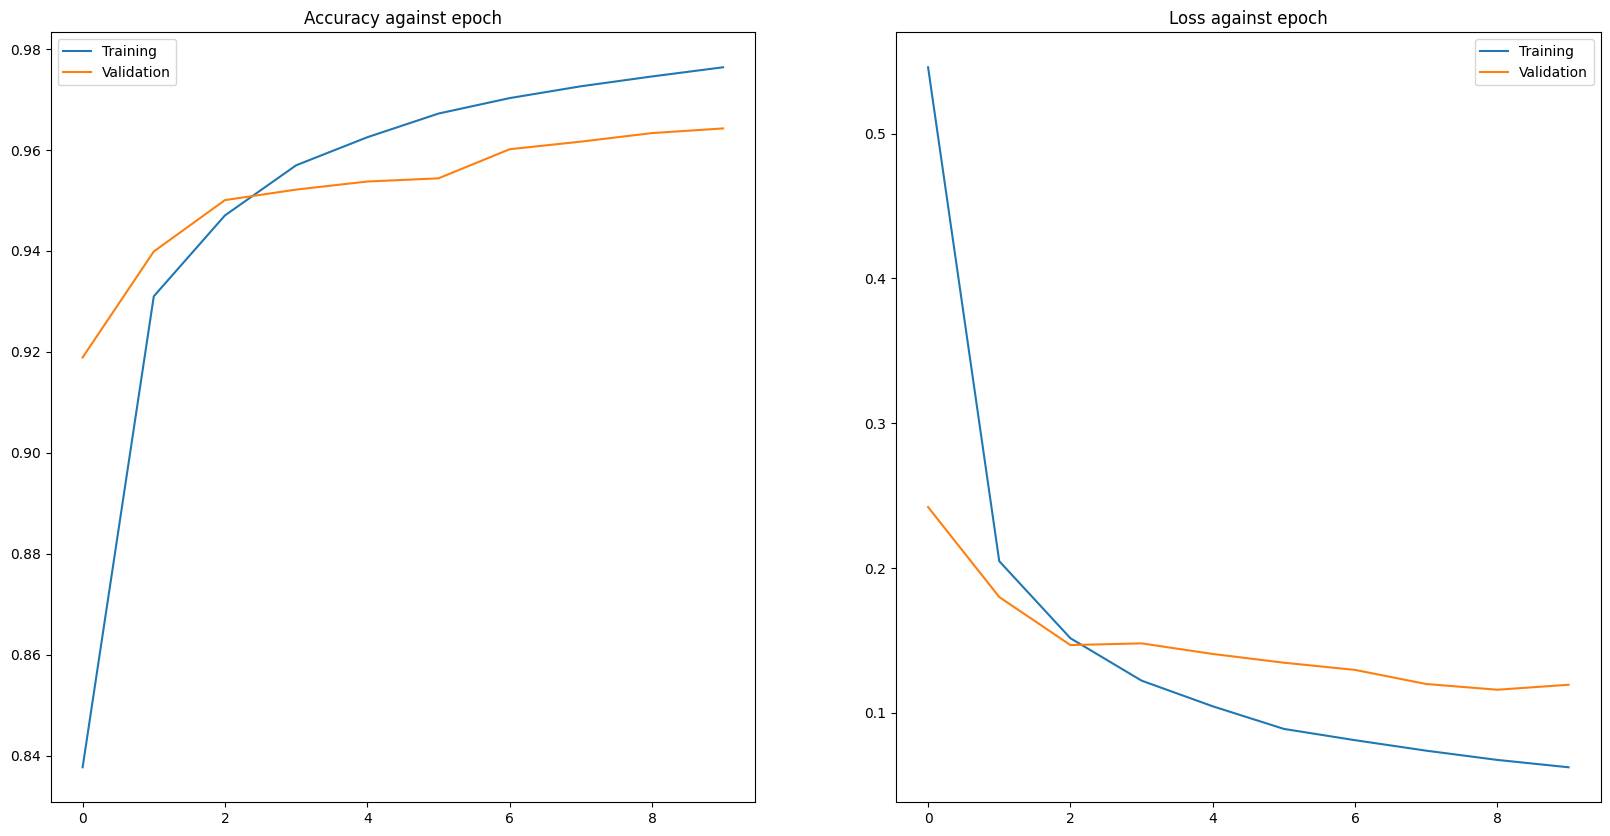

In [35]:
# Plot val and train accuracy and loss
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))  # Adjust figsize as needed
labels = ["Training", "Validation"]
# Plot accuracy data
axes[0].set_title("Accuracy against epoch")
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].legend(labels)
# Plot loss data
axes[1].set_title("Loss against epoch")
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].legend(labels)

plt.show()

In [ ]:
test_Y = le.inverse_transform(test_Y)
test_Y_pred = model.predict(test_X)

In [40]:
x = np.argmax(test_Y_pred, axis=1)
x = le.inverse_transform(x)

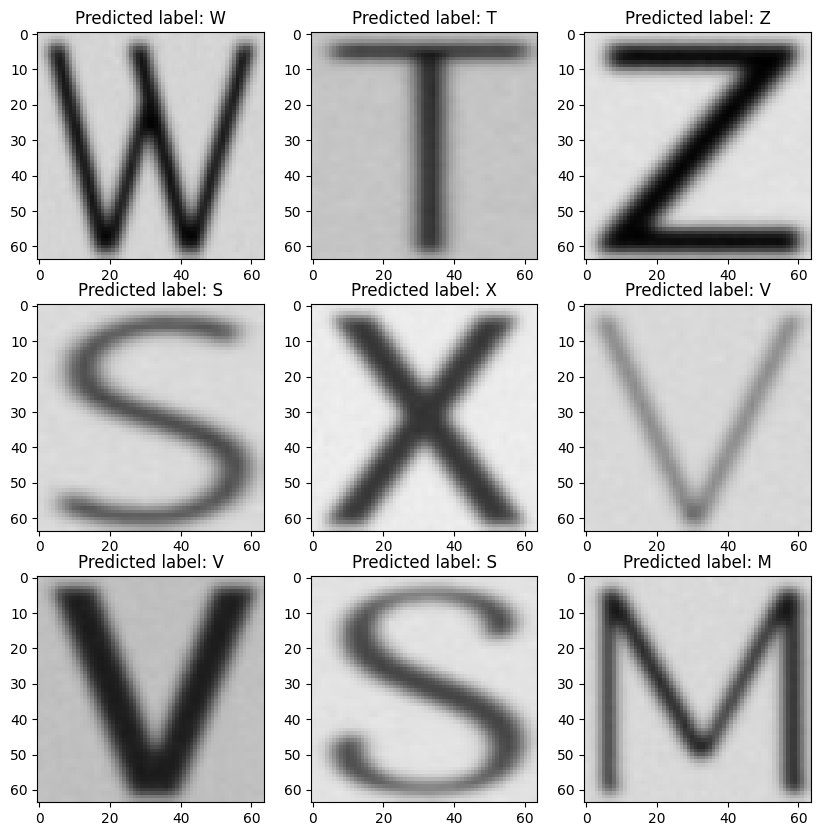

In [41]:
# Look at sample of 10 test data items
rows, cols = 3, 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 10))  # Adjust figsize as needed
axes = axes.flatten()
# Go through 
for i in range(rows * cols):
    axes[i].imshow(test_X[i])
    axes[i].set_title(f"Predicted label: {x[i]}")
plt.show()

In [1]:
model.save('my_model.keras')

NameError: name 'model' is not defined